# Imports

In [1]:
from __future__ import print_function, division
!pip install densenet_pytorch
!pip install grad-cam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.utils.data as data
from densenet_pytorch import DenseNet
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.models as models
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

torch.manual_seed(17)
cudnn.benchmark = True
plt.ion()   # interactive mode
num_classes = 2
from google.colab import drive
drive.mount('/content/gdrive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=902877dcaff28fe0517d91aa28c658444fc921bbebde9fce1946555e6865a4f3
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam
Mounted at /content/gdrive


# Data Loader

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler


def get_train_valid_loader(data_dir, test_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.4,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """

    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transforms
    valid_transform = transforms.Compose([transforms.Resize((224,224)),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize])
    if augment:
        train_transform = transforms.Compose([
            transforms.Resize((224,224)),
        transforms.RandomRotation(degrees=(-20, 20)),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                                       #transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       #transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       normalize])
    else:
        train_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize])

    # load the dataset
    train_dataset = datasets.ImageFolder(
        root=data_dir, transform=train_transform,
    )

    valid_dataset = datasets.ImageFolder(
        root=data_dir, transform=valid_transform,
    )
    test_dataset = datasets.ImageFolder(
        root=data_dir, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    rest_split = int(split/2)

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx, test_idx = indices[split:], indices[rest_split:split], indices[:rest_split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    print(len(train_idx))
    print(len(valid_idx))
    print(len(train_sampler))
    print(len(valid_sampler))
    print(len(test_sampler))
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,drop_last=True
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,drop_last=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, num_workers=num_workers,sampler=test_sampler, pin_memory=pin_memory
    )

    return (train_loader, valid_loader, test_loader, len(train_idx), len(valid_idx), train_dataset.classes)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

data_dir = '/content/gdrive/My Drive/EECE571F/project/covid_data_new'
test_dir = '/content/gdrive/My Drive/EECE571F/project/covid_data_new'
train_loader, val_loader, test_loader, train_size, val_size, class_names= get_train_valid_loader(data_dir,
                           test_dir,
                           32,
                           True,
                           10,
                           valid_size=0.4,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=True)
#image_datasets = {'train': datasets.ImageFolder(os.path.join(data_dir, 'train'),data_transforms['train']),
#          'val': datasets.ImageFolder(os.path.join(data_dir, 'val'),data_transforms['val'])}
#dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32,shuffle=True, num_workers=2, drop_last=True),
#        'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32,shuffle=True, num_workers=2, drop_last=True)}
dataloaders = {'train':train_loader,
               'val':val_loader}
dataset_sizes = {'train': train_size,
          'val': val_size}
print(dataset_sizes['train'])
print(dataset_sizes['val'])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2503
834
2503
834
834
2503
834


# Helper function

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
#inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
#out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def test_model(testloader, model):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

  print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')


In [ ]:
def save_model(model, file_path = '/content/gdrive/My Drive/EECE571F/project/saved_', model_name = 'attndense', model_no = 1, file_format='.pt'):
  saved_model_path = file_path+model_name+'_'+str(model_no)+file_format
  torch.save(model.state_dict(), saved_model_path)

In [ ]:
def load_model(model_class, file_path = '/content/gdrive/My Drive/EECE571F/project/saved_', model_name = 'attndense', model_no = 1, file_format='.pt'):
  saved_model_path = file_path+model_name+'_'+str(model_no)+file_format
  model3 = model_class()
  model3.to('cuda')
  model3.load_state_dict(torch.load(saved_model_path))
  return model3
  #test_model(test_loader, model=model3)

# Train function

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train_model(model, criterion, optimizer, scheduler, num_epochs, model_name, runs=0):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopper = EarlyStopper(patience=10, min_delta=5e-3)
    early_stopping = False
    ######## Draw loss and accuracy ##############
    y_loss = {}  # loss history
    y_loss['train'] = []
    y_loss['val'] = []
    y_err = {}
    y_err['train'] = []
    y_err['val'] = []

    x_epoch = []
    fig = plt.figure()
    ax0 = fig.add_subplot(121, title="loss")
    ax1 = fig.add_subplot(122, title="top1err")


    def draw_curve(current_epoch):
        x_epoch.append(current_epoch)
        ax0.plot(x_epoch, y_loss['train'], 'b', label='train')
        ax0.plot(x_epoch, y_loss['val'], 'r', label='val')
        ax1.plot(x_epoch, y_err['train'], 'b', label='train')
        ax1.plot(x_epoch, y_err['val'], 'r', label='val')
        if current_epoch == 0:
            ax0.legend()
            ax1.legend()
        fig.savefig('/content/gdrive/My Drive/EECE571F/project/lossplots/'+model_name+str(runs)+'.png')
    ###############################################################

    ############## Training process ############################
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #if phase == 'train':
            #    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            y_loss[phase].append(epoch_loss)
            y_err[phase].append(torch.Tensor.cpu(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val':
                scheduler.step(epoch_loss)
                # draw loss and acc curve
                draw_curve(epoch)

                # deep copy the model
                if epoch_acc>best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
                early_stopping = early_stopper.early_stop(epoch_loss)
        if early_stopping:
          print('Early stopping.')
          break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#visualize_model(model_ft)
#test_model(test_loader, model=model_ft)

# ChannelAttention, SpatialAttention block

In [2]:
class ChannelAttention(nn.Module):
    def __init__(self, in_features, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(nn.Conv2d(in_features, in_features // ratio, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_features // ratio, in_features, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CSAttentionBlock(nn.Module):
    def __init__(self, in_features, ratio=16, kernel_size=7):
        super(CSAttentionBlock, self).__init__()

        self.channel_attention = ChannelAttention(in_features=in_features, ratio=ratio)
        self.spatial_attention = SpatialAttention(kernel_size=kernel_size)
        self.relu = nn.ReLU(inplace=True)
        #self.bn = nn.BatchNorm2d(in_features)
        #self.conv1 = nn.Conv2d(in_channels=in_features*2,out_channels=in_features, kernel_size=1)
        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        residual = x
        out = self.channel_attention(x)*x
        out = self.spatial_attention(out)*out

        #if self.downsample is not None:
        #    residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        #out = self.bn(out)
        #out = self.dropout(out)
        return out

class CAttentionBlock(nn.Module):
    def __init__(self, in_features, ratio=16, kernel_size=7):
        super(CAttentionBlock, self).__init__()

        self.channel_attention = ChannelAttention(in_features=in_features, ratio=ratio)
        self.relu = nn.ReLU(inplace=True)
        #self.bn = nn.BatchNorm2d(in_features)
        #self.conv1 = nn.Conv2d(in_channels=in_features*2,out_channels=in_features, kernel_size=1)
        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        residual = x
        out = self.channel_attention(x)*x

        #if self.downsample is not None:
        #    residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        #out = self.bn(out)
        #out = self.dropout(out)
        return out

class SAttentionBlock(nn.Module):
    def __init__(self, in_features, ratio=16, kernel_size=7):
        super(SAttentionBlock, self).__init__()

        self.spatial_attention = SpatialAttention(kernel_size=kernel_size)
        self.relu = nn.ReLU(inplace=True)
        #self.bn = nn.BatchNorm2d(in_features)
        #self.conv1 = nn.Conv2d(in_channels=in_features*2,out_channels=in_features, kernel_size=1)
        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        residual = x
        out = self.spatial_attention(x)*x

        #if self.downsample is not None:
        #    residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        #out = self.bn(out)
        #out = self.dropout(out)
        return out

# Attention densenet （attention kernel size较大可改）

In [3]:
from torchsummary import summary
class AttnDense(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(AttnDense,self).__init__()
        model_ft = DenseNet.from_pretrained("densenet201")
        net = model_ft
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding=1)
        self.stem = nn.Sequential(*list(net.features.children())[0:4])
        self.dense_block0 = nn.Sequential(list(net.features.children())[4])
        self.transit_block0 = nn.Sequential(*list(net.features.children())[5])
        self.dense_block1 = nn.Sequential(list(net.features.children())[6])
        self.transit_block1 = nn.Sequential(*list(net.features.children())[7])
        self.dense_block2 = nn.Sequential(list(net.features.children())[8])
        self.transit_block2 = nn.Sequential(*list(net.features.children())[9])
        self.dense_block3 = nn.Sequential(list(net.features.children())[10])
        self.batchnorm = net.features[11]

        denseblock0_outfeature=256
        denseblock1_outfeature=512
        denseblock2_outfeature=1792
        denseblock3_outfeature=1920
        #self.atten0 = AttentionBlock(in_features_l=denseblock0_outfeature, in_features_g=denseblock3_outfeature, attn_features=256, up_factor=8, normalize_attn=True)
        #self.atten1 = AttentionBlock(in_features_l=denseblock1_outfeature, in_features_g=denseblock3_outfeature, attn_features=256, up_factor=4, normalize_attn=True)
        #self.atten2 = AttentionBlock(in_features_l=denseblock2_outfeature, in_features_g=denseblock3_outfeature, attn_features=256, up_factor=2, normalize_attn=True)
        self.atten0 = CSAttentionBlock(in_features=denseblock0_outfeature, kernel_size=7, ratio=16)
        self.atten1 = CSAttentionBlock(in_features=denseblock1_outfeature, kernel_size=7, ratio=16)
        self.atten2 = CSAttentionBlock(in_features=denseblock2_outfeature, kernel_size=7, ratio=16)
        self.atten3 = CSAttentionBlock(in_features=denseblock3_outfeature, kernel_size=7, ratio=16)

        self.pooling = nn.Sequential(
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
            )
        self.classifier = nn.Sequential(
            #nn.Linear(denseblock0_outfeature+denseblock1_outfeature+denseblock2_outfeature+denseblock3_outfeature, 128), #downsample
            nn.Linear(denseblock3_outfeature, 128), #downsample
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes),  #classifier
        )

    def forward(self, x):
        out = self.stem(x)
        out = self.dense_block0(out)
        out = self.atten0(out)
        #l0 = out
        out = self.transit_block0(out)

        out = self.dense_block1(out)
        out = self.atten1(out)
        #l1 = out
        out = self.transit_block1(out)

        out = self.dense_block2(out)
        out = self.atten2(out)
        #l2 = out
        out = self.transit_block2(out)

        out = self.dense_block3(out)
        out = self.atten3(out)
        out = self.batchnorm(out)
        #g = out
        #_, atten0 = self.atten0(l0,g)
        #_, atten1 = self.atten1(l1,g)
        #_, atten2 = self.atten2(l2,g)
        out = self.pooling(out)
        #out = torch.cat((out,atten0,atten1,atten2), dim=1)
        out = self.classifier(out)
        return out

train with adamW

Loaded pretrained weights for densenet201
Epoch 0/49
----------
train Loss: 0.5734 Acc: 0.7083
val Loss: 0.6850 Acc: 0.7374

Epoch 1/49
----------
train Loss: 0.4470 Acc: 0.7986
val Loss: 0.4426 Acc: 0.7914

Epoch 2/49
----------
train Loss: 0.3859 Acc: 0.8310
val Loss: 0.6437 Acc: 0.7230

Epoch 3/49
----------
train Loss: 0.3353 Acc: 0.8486
val Loss: 0.2974 Acc: 0.8933

Epoch 4/49
----------
train Loss: 0.3063 Acc: 0.8686
val Loss: 0.2855 Acc: 0.8801

Epoch 5/49
----------
train Loss: 0.2985 Acc: 0.8793
val Loss: 0.4763 Acc: 0.8010

Epoch 6/49
----------
train Loss: 0.2852 Acc: 0.8785
val Loss: 0.5330 Acc: 0.7446

Epoch 7/49
----------
train Loss: 0.2636 Acc: 0.8961
val Loss: 0.5132 Acc: 0.8046

Epoch 8/49
----------
train Loss: 0.2648 Acc: 0.8981
val Loss: 0.3668 Acc: 0.8429

Epoch 9/49
----------
train Loss: 0.2453 Acc: 0.8981
val Loss: 0.2699 Acc: 0.8945

Epoch 10/49
----------
train Loss: 0.2424 Acc: 0.9017
val Loss: 1.1291 Acc: 0.6463

Epoch 11/49
----------
train Loss: 0.2315 Ac

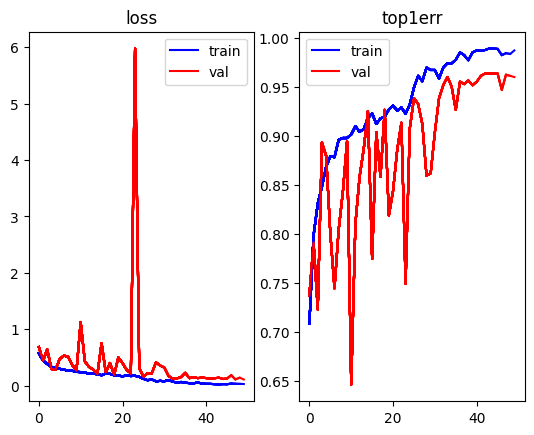

In [ ]:
attendense = AttnDense(num_classes=2)
attendense = attendense.cuda()
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(attendense.parameters(), lr=1e-3)
# Decay LR by a factor of 0.7 every 5 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = 0.5, patience = 5, verbose = 1) #from 1e-4
attendense = train_model(attendense, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50, model_name='AttnDense', runs=10)
test_model(test_loader, model=attendense)
save_model(model=attendense, model_no=10)

train with adamW

Loaded pretrained weights for densenet201
Epoch 0/49
----------
train Loss: 0.5422 Acc: 0.7191
val Loss: 0.4480 Acc: 0.7854

Epoch 1/49
----------
train Loss: 0.3990 Acc: 0.8214
val Loss: 0.4144 Acc: 0.8153

Epoch 2/49
----------
train Loss: 0.3174 Acc: 0.8626
val Loss: 0.4001 Acc: 0.8237

Epoch 3/49
----------
train Loss: 0.3276 Acc: 0.8654
val Loss: 0.7040 Acc: 0.6906

Epoch 4/49
----------
train Loss: 0.2878 Acc: 0.8841
val Loss: 0.4000 Acc: 0.8405

Epoch 5/49
----------
train Loss: 0.3137 Acc: 0.8670
val Loss: 0.2931 Acc: 0.8669

Epoch 6/49
----------
train Loss: 0.2637 Acc: 0.8913
val Loss: 0.5520 Acc: 0.8022

Epoch 7/49
----------
train Loss: 0.2374 Acc: 0.9009
val Loss: 0.3841 Acc: 0.8453

Epoch 8/49
----------
train Loss: 0.2431 Acc: 0.8921
val Loss: 0.2322 Acc: 0.9101

Epoch 9/49
----------
train Loss: 0.2405 Acc: 0.9029
val Loss: 0.3518 Acc: 0.8309

Epoch 10/49
----------
train Loss: 0.2300 Acc: 0.9037
val Loss: 1.2463 Acc: 0.6715

Epoch 11/49
----------
train Loss: 0.2224 Ac

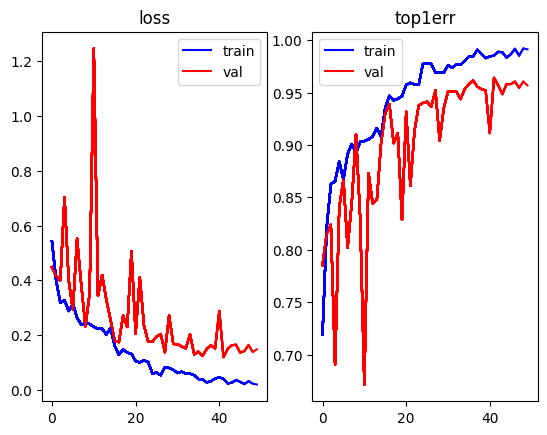

In [ ]:
attendense3 = AttnDense(num_classes=2)
attendense3 = attendense3.cuda()
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(attendense3.parameters(), lr=1e-3)
# Decay LR by a factor of 0.7 every 5 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = 0.5, patience = 5, verbose = 1) #from 1e-4
attendense3 = train_model(attendense3, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50, model_name='AttnDense', runs=11)
test_model(test_loader, model=attendense3)
save_model(model=attendense3, model_no=11, model_name = 'AttnDense')

test model

In [ ]:
model_test = load_model(model_class=AttnDense, model_no=10)
test_model(test_loader, model=model_test)

Loaded pretrained weights for densenet201
Accuracy of the network on the 834 test images: 97.84172661870504 %


Loaded pretrained weights for densenet201


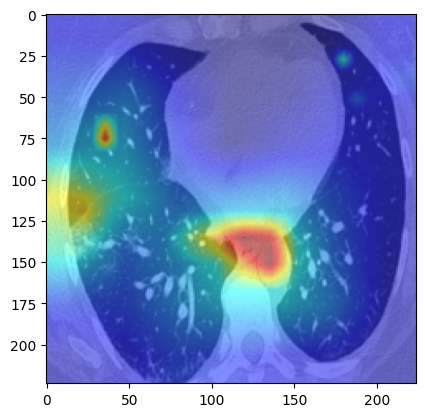

In [ ]:
model = load_model(model_class=AttnDense, model_no=10)

target_layers = [model.dense_block0, model.dense_block1, model.dense_block2, model.dense_block3]
#target_layers = [model.atten0, model.atten1, model.atten2, model.atten3]
img_path = '/content/gdrive/My Drive/EECE571F/project/covid_data_new/Covid/Patient (80)/25.png'
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path).convert('RGB')
img = img.resize((224,224))
img = np.array(img, dtype=np.uint8)
valid_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224,224)),
                                      #transforms.CenterCrop(224),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
img_tensor = valid_transform(img)
input_tensor = torch.unsqueeze(img_tensor, dim=0)

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)


targets = None
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(np.float32(img) / 255., grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.show()

# Original Densenet for comparison

In [ ]:

model_ft = DenseNet.from_pretrained("densenet201")
n_features_classify = model_ft.classifier.in_features
class net_add(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.BatchNorm1d(n_features_classify),
            nn.Linear(n_features_classify, num_classes), #downsample
            #nn.ReLU(),
            #nn.BatchNorm1d(128),
            #nn.Dropout(p=0.3),
            #nn.Linear(128, 64),
            #nn.ReLU(),
            #nn.BatchNorm1d(64),
            #nn.Linear(64, num_classes),  #classifier
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output
net_add = net_add()
model_ft.classifier = net_add
model_ft = model_ft.cuda()
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.002)
# Decay LR by a factor of 0.7 every 5 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = 0.70, patience = 5, verbose = 1, min_lr = 1e-4)

Loaded pretrained weights for densenet201


Epoch 0/49
----------
train Loss: 0.6947 Acc: 0.6816
val Loss: 0.5882 Acc: 0.7074

Epoch 1/49
----------
train Loss: 0.5807 Acc: 0.7167
val Loss: 1.6814 Acc: 0.5683

Epoch 2/49
----------
train Loss: 0.5989 Acc: 0.6996
val Loss: 0.8152 Acc: 0.5276

Epoch 3/49
----------
train Loss: 0.5052 Acc: 0.7707
val Loss: 0.7199 Acc: 0.7542

Epoch 4/49
----------
train Loss: 0.4594 Acc: 0.7926
val Loss: 0.6393 Acc: 0.7230

Epoch 5/49
----------
train Loss: 0.4394 Acc: 0.8066
val Loss: 0.5456 Acc: 0.7662

Epoch 6/49
----------
train Loss: 0.4114 Acc: 0.8266
val Loss: 0.5128 Acc: 0.7422

Epoch 7/49
----------
train Loss: 0.4176 Acc: 0.8190
val Loss: 0.3656 Acc: 0.8309

Epoch 8/49
----------
train Loss: 0.3689 Acc: 0.8382
val Loss: 1.1841 Acc: 0.6199

Epoch 9/49
----------
train Loss: 0.3532 Acc: 0.8506
val Loss: 0.4539 Acc: 0.7926

Epoch 10/49
----------
train Loss: 0.4066 Acc: 0.8086
val Loss: 0.4353 Acc: 0.7770

Epoch 11/49
----------
train Loss: 0.3781 Acc: 0.8382
val Loss: 0.6307 Acc: 0.7086

Ep

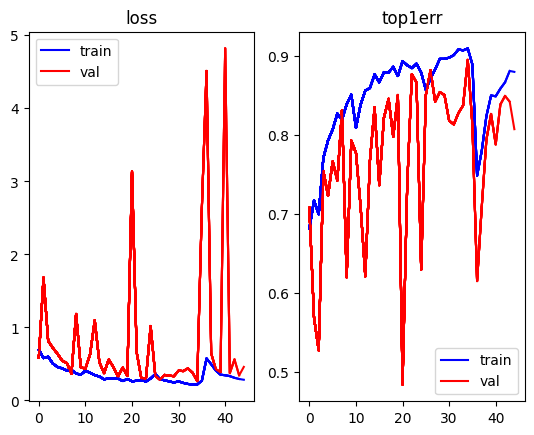

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50, model_name='densenet', runs=10)
test_model(test_loader, model=model_ft)

# Original VGG16 for comparison

In [ ]:
model_vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
n_features_classify = 25088
class net_add(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features_classify, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),  #classifier
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output
net_add = net_add()
model_vgg.classifier = net_add
model_vgg = model_vgg.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_vgg.parameters(), lr=0.003)
# Decay LR by a factor of 0.7 every 5 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = 0.70, patience = 5, verbose = 1, min_lr = 1e-4)

Epoch 0/49
----------
train Loss: 34.0119 Acc: 0.5126
val Loss: 0.6941 Acc: 0.4580

Epoch 1/49
----------
train Loss: 0.8606 Acc: 0.4954
val Loss: 0.6913 Acc: 0.5336

Epoch 2/49
----------
train Loss: 0.7865 Acc: 0.5218
val Loss: 0.6880 Acc: 0.5408

Epoch 3/49
----------
train Loss: 0.6917 Acc: 0.5134
val Loss: 0.6895 Acc: 0.5408

Epoch 4/49
----------
train Loss: 0.6914 Acc: 0.4998
val Loss: 0.6914 Acc: 0.5396

Epoch 5/49
----------
train Loss: 0.6918 Acc: 0.5138
val Loss: 0.6892 Acc: 0.5396

Epoch 6/49
----------
train Loss: 0.6911 Acc: 0.5082
val Loss: 0.6892 Acc: 0.5396

Epoch 7/49
----------
train Loss: 0.6907 Acc: 0.5126
val Loss: 0.6889 Acc: 0.5396

Epoch 8/49
----------
train Loss: 0.6909 Acc: 0.5138
val Loss: 0.6906 Acc: 0.5396
Epoch 00009: reducing learning rate of group 0 to 2.1000e-03.

Epoch 9/49
----------
train Loss: 0.6907 Acc: 0.5146
val Loss: 0.6903 Acc: 0.5396

Epoch 10/49
----------
train Loss: 0.6911 Acc: 0.5098
val Loss: 0.6897 Acc: 0.5396

Epoch 11/49
----------


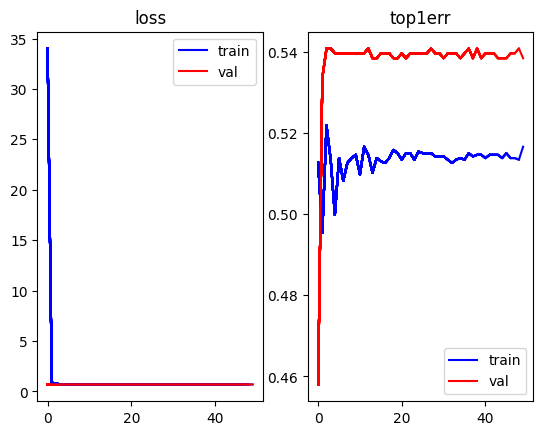

In [ ]:
model_vgg = train_model(model_vgg, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50, model_name='vgg16', runs=10)
test_model(test_loader, model=model_vgg)

# Original Googlenet for comparison

In [ ]:
model_googlenet = models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 71.7MB/s]


In [ ]:
n_features_classify = 1024
model_googlenet.fc = nn.Linear(n_features_classify, num_classes)
model_googlenet = model_googlenet.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_googlenet.parameters(), lr=0.003)
# Decay LR by a factor of 0.7 every 5 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = 0.50, patience = 5, verbose = 1, min_lr = 1e-4)

Epoch 0/49
----------
train Loss: 0.5614 Acc: 0.7115
val Loss: 1.0645 Acc: 0.7170

Epoch 1/49
----------
train Loss: 0.4745 Acc: 0.7819
val Loss: 0.5052 Acc: 0.7446

Epoch 2/49
----------
train Loss: 0.4056 Acc: 0.8218
val Loss: 0.6017 Acc: 0.6835

Epoch 3/49
----------
train Loss: 0.3698 Acc: 0.8374
val Loss: 1.0704 Acc: 0.6463

Epoch 4/49
----------
train Loss: 0.3348 Acc: 0.8562
val Loss: 0.5556 Acc: 0.7266

Epoch 5/49
----------
train Loss: 0.3318 Acc: 0.8518
val Loss: 0.8483 Acc: 0.6367

Epoch 6/49
----------
train Loss: 0.3202 Acc: 0.8590
val Loss: 0.5264 Acc: 0.7578

Epoch 7/49
----------
train Loss: 0.3171 Acc: 0.8642
val Loss: 2.1263 Acc: 0.5875
Epoch 00008: reducing learning rate of group 0 to 1.5000e-03.

Epoch 8/49
----------
train Loss: 0.2877 Acc: 0.8765
val Loss: 0.3214 Acc: 0.8645

Epoch 9/49
----------
train Loss: 0.2539 Acc: 0.8897
val Loss: 0.2527 Acc: 0.9041

Epoch 10/49
----------
train Loss: 0.2461 Acc: 0.8949
val Loss: 0.3774 Acc: 0.8309

Epoch 11/49
----------
t

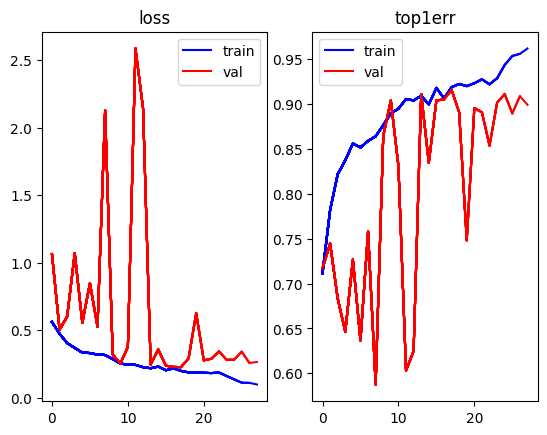

In [ ]:
model_googlenet = train_model(model_googlenet, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50, model_name='googlenet', runs=10)
test_model(test_loader, model=model_googlenet)

# Attention Googlenet

In [ ]:
from torchsummary import summary

class AttnGNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(AttnGNet,self).__init__()
        model_ft = models.googlenet(pretrained=True)
        net = model_ft

        inception3_outfeature=480
        inception4_outfeature=832
        inception5_outfeature=1024
        self.stem = nn.Sequential(*list(net.children())[0:5])
        self.inception3 = nn.Sequential(*list(net.children())[5:7])
        self.atten3 = CSAttentionBlock(in_features=inception3_outfeature, kernel_size=7, ratio=16)
        self.pooling3 = nn.Sequential(list(net.children())[7])

        self.inception4 = nn.Sequential(*list(net.children())[8:13])
        self.atten4 = CSAttentionBlock(in_features=inception4_outfeature, kernel_size=7, ratio=16)
        self.pooling4 = nn.Sequential(list(net.children())[13])

        self.inception5 = nn.Sequential(*list(net.children())[14:16])
        self.atten5 = CSAttentionBlock(in_features=inception5_outfeature, kernel_size=7, ratio=16)
        self.pooling5 = nn.Sequential(list(net.children())[16])





        self.dropout = nn.Sequential(list(net.children())[17])
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.stem(x)
        out = self.inception3(out)
        out = self.atten3(out)
        #l0 = out
        out = self.pooling3(out)

        out = self.inception4(out)
        out = self.atten4(out)
        #l0 = out
        out = self.pooling4(out)

        out = self.inception5(out)
        out = self.atten5(out)
        #l0 = out
        out = self.pooling5(out)
        out = torch.flatten(out, 1)

        out = self.dropout(out)
        out = self.classifier(out)

        return out

Epoch 0/49
----------
train Loss: 0.4525 Acc: 0.7875
val Loss: 0.3491 Acc: 0.8465

Epoch 1/49
----------
train Loss: 0.3115 Acc: 0.8686
val Loss: 0.2831 Acc: 0.8705

Epoch 2/49
----------
train Loss: 0.2962 Acc: 0.8777
val Loss: 0.2540 Acc: 0.9053

Epoch 3/49
----------
train Loss: 0.2526 Acc: 0.8949
val Loss: 0.2388 Acc: 0.8993

Epoch 4/49
----------
train Loss: 0.2361 Acc: 0.9037
val Loss: 0.2656 Acc: 0.9017

Epoch 5/49
----------
train Loss: 0.2369 Acc: 0.8973
val Loss: 0.5658 Acc: 0.7398

Epoch 6/49
----------
train Loss: 0.2018 Acc: 0.9209
val Loss: 0.9828 Acc: 0.6906

Epoch 7/49
----------
train Loss: 0.2044 Acc: 0.9173
val Loss: 0.2852 Acc: 0.9029

Epoch 8/49
----------
train Loss: 0.2037 Acc: 0.9145
val Loss: 0.4455 Acc: 0.8058

Epoch 9/49
----------
train Loss: 0.1685 Acc: 0.9329
val Loss: 0.5231 Acc: 0.7974
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.

Epoch 10/49
----------
train Loss: 0.1354 Acc: 0.9481
val Loss: 0.1598 Acc: 0.9353

Epoch 11/49
----------
t

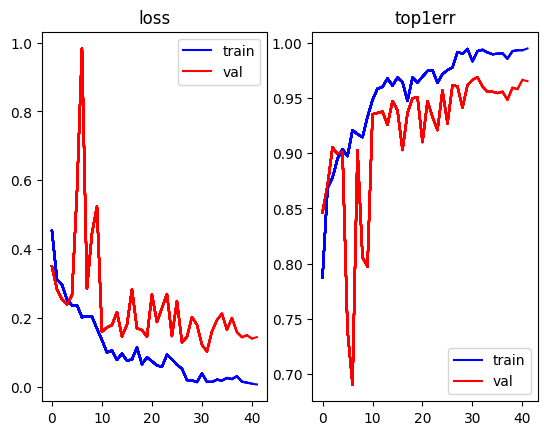

In [ ]:
attengnet = AttnGNet(num_classes=2)
attengnet = attengnet.cuda()
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(attengnet.parameters(), lr=1e-3)
# Decay LR by a factor of 0.7 every 5 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = 0.5, patience = 5, verbose = 1) #from 1e-4
attengnet = train_model(attengnet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50, model_name='AttnGNet', runs=10)
test_model(test_loader, model=attengnet)
save_model(model=attengnet, model_no=10, model_name = 'attnGNet')

In [ ]:
model_ft = models.googlenet(pretrained=True)
print(list(model_ft.children())[16])

AdaptiveAvgPool2d(output_size=(1, 1))


# Resnet

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


In [ ]:
model.fc = nn.Linear(2048, 2, bias = True)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model.parameters(), lr=0.003)
# Decay LR by a factor of 0.7 every 5 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = 0.70, patience = 5, verbose = 1, min_lr = 1e-4)

Epoch 0/49
----------
train Loss: 0.7949 Acc: 0.5801
val Loss: 7.0191 Acc: 0.5264

Epoch 1/49
----------
train Loss: 0.6357 Acc: 0.6484
val Loss: 0.7444 Acc: 0.5851

Epoch 2/49
----------
train Loss: 0.5411 Acc: 0.7331
val Loss: 0.4941 Acc: 0.7542

Epoch 3/49
----------
train Loss: 0.5117 Acc: 0.7627
val Loss: 7.0358 Acc: 0.5408

Epoch 4/49
----------
train Loss: 0.5456 Acc: 0.7319
val Loss: 0.4951 Acc: 0.7458

Epoch 5/49
----------
train Loss: 0.5131 Acc: 0.7535
val Loss: 0.7339 Acc: 0.6007

Epoch 6/49
----------
train Loss: 0.4876 Acc: 0.7707
val Loss: 0.9279 Acc: 0.5540

Epoch 7/49
----------
train Loss: 0.4584 Acc: 0.7887
val Loss: 2.3345 Acc: 0.5803

Epoch 8/49
----------
train Loss: 0.4433 Acc: 0.7903
val Loss: 1.5096 Acc: 0.5791
Epoch 00009: reducing learning rate of group 0 to 2.1000e-03.

Epoch 9/49
----------
train Loss: 0.4347 Acc: 0.8018
val Loss: 0.4320 Acc: 0.7734

Epoch 10/49
----------
train Loss: 0.4089 Acc: 0.8178
val Loss: 0.4494 Acc: 0.7866

Epoch 11/49
----------
t

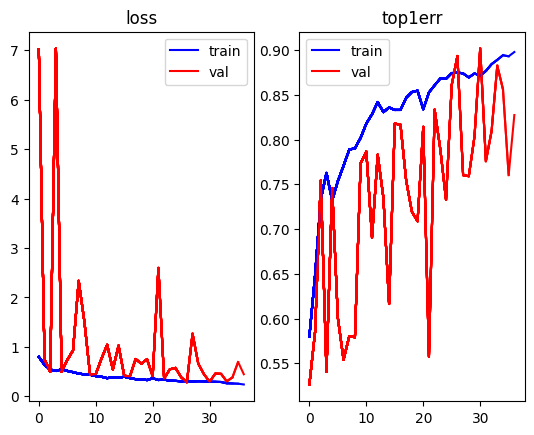

In [ ]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50, model_name='resnet50', runs=10)
test_model(test_loader, model=model)

# Ablation C only

In [ ]:
from torchsummary import summary
class CAttnDense(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(CAttnDense,self).__init__()
        model_ft = DenseNet.from_pretrained("densenet201")
        net = model_ft
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding=1)
        self.stem = nn.Sequential(*list(net.features.children())[0:4])
        self.dense_block0 = nn.Sequential(list(net.features.children())[4])
        self.transit_block0 = nn.Sequential(*list(net.features.children())[5])
        self.dense_block1 = nn.Sequential(list(net.features.children())[6])
        self.transit_block1 = nn.Sequential(*list(net.features.children())[7])
        self.dense_block2 = nn.Sequential(list(net.features.children())[8])
        self.transit_block2 = nn.Sequential(*list(net.features.children())[9])
        self.dense_block3 = nn.Sequential(list(net.features.children())[10])
        self.batchnorm = net.features[11]

        denseblock0_outfeature=256
        denseblock1_outfeature=512
        denseblock2_outfeature=1792
        denseblock3_outfeature=1920
        #self.atten0 = AttentionBlock(in_features_l=denseblock0_outfeature, in_features_g=denseblock3_outfeature, attn_features=256, up_factor=8, normalize_attn=True)
        #self.atten1 = AttentionBlock(in_features_l=denseblock1_outfeature, in_features_g=denseblock3_outfeature, attn_features=256, up_factor=4, normalize_attn=True)
        #self.atten2 = AttentionBlock(in_features_l=denseblock2_outfeature, in_features_g=denseblock3_outfeature, attn_features=256, up_factor=2, normalize_attn=True)
        self.atten0 = CAttentionBlock(in_features=denseblock0_outfeature, kernel_size=7, ratio=16)
        self.atten1 = CAttentionBlock(in_features=denseblock1_outfeature, kernel_size=7, ratio=16)
        self.atten2 = CAttentionBlock(in_features=denseblock2_outfeature, kernel_size=7, ratio=16)
        self.atten3 = CAttentionBlock(in_features=denseblock3_outfeature, kernel_size=7, ratio=16)

        self.pooling = nn.Sequential(
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
            )
        self.classifier = nn.Sequential(
            #nn.Linear(denseblock0_outfeature+denseblock1_outfeature+denseblock2_outfeature+denseblock3_outfeature, 128), #downsample
            nn.Linear(denseblock3_outfeature, 128), #downsample
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes),  #classifier
        )

    def forward(self, x):
        out = self.stem(x)
        out = self.dense_block0(out)
        out = self.atten0(out)
        #l0 = out
        out = self.transit_block0(out)

        out = self.dense_block1(out)
        out = self.atten1(out)
        #l1 = out
        out = self.transit_block1(out)

        out = self.dense_block2(out)
        out = self.atten2(out)
        #l2 = out
        out = self.transit_block2(out)

        out = self.dense_block3(out)
        out = self.atten3(out)
        out = self.batchnorm(out)
        #g = out
        #_, atten0 = self.atten0(l0,g)
        #_, atten1 = self.atten1(l1,g)
        #_, atten2 = self.atten2(l2,g)
        out = self.pooling(out)
        #out = torch.cat((out,atten0,atten1,atten2), dim=1)
        out = self.classifier(out)
        return out

Loaded pretrained weights for densenet201
Epoch 0/49
----------
train Loss: 0.5682 Acc: 0.6904
val Loss: 0.5296 Acc: 0.7398

Epoch 1/49
----------
train Loss: 0.3998 Acc: 0.8198
val Loss: 0.3598 Acc: 0.8357

Epoch 2/49
----------
train Loss: 0.3537 Acc: 0.8450
val Loss: 0.3194 Acc: 0.8525

Epoch 3/49
----------
train Loss: 0.3130 Acc: 0.8642
val Loss: 0.3065 Acc: 0.8609

Epoch 4/49
----------
train Loss: 0.2844 Acc: 0.8829
val Loss: 0.2611 Acc: 0.8873

Epoch 5/49
----------
train Loss: 0.2954 Acc: 0.8738
val Loss: 0.2636 Acc: 0.8957

Epoch 6/49
----------
train Loss: 0.2748 Acc: 0.8817
val Loss: 0.5302 Acc: 0.7206

Epoch 7/49
----------
train Loss: 0.2484 Acc: 0.8981
val Loss: 0.2535 Acc: 0.8921

Epoch 8/49
----------
train Loss: 0.2397 Acc: 0.9001
val Loss: 0.4960 Acc: 0.7746

Epoch 9/49
----------
train Loss: 0.2109 Acc: 0.9121
val Loss: 0.3126 Acc: 0.8657

Epoch 10/49
----------
train Loss: 0.2220 Acc: 0.9041
val Loss: 0.5826 Acc: 0.7638

Epoch 11/49
----------
train Loss: 0.2185 Ac

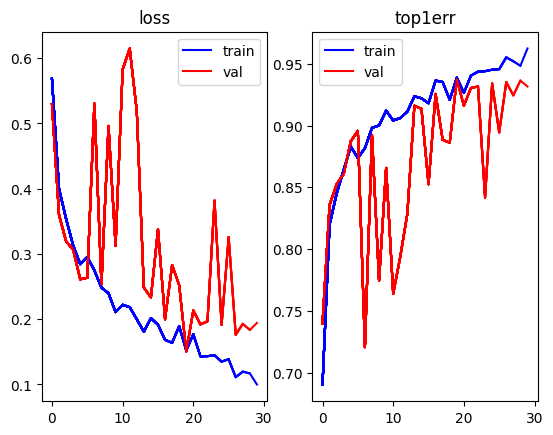

In [ ]:
cattendense = CAttnDense(num_classes=2)
cattendense = cattendense.cuda()
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(cattendense.parameters(), lr=1e-3)
# Decay LR by a factor of 0.7 every 5 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = 0.7, patience = 5, verbose = 1) #from 1e-4
cattendense = train_model(cattendense, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50, model_name='CAttnDense', runs=10)
test_model(test_loader, model=cattendense)
save_model(model=cattendense, model_no=10, model_name= 'CAttnDense')


# Ablation S Only

In [ ]:
from torchsummary import summary
class SAttnDense(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(SAttnDense,self).__init__()
        model_ft = DenseNet.from_pretrained("densenet201")
        net = model_ft
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding=1)
        self.stem = nn.Sequential(*list(net.features.children())[0:4])
        self.dense_block0 = nn.Sequential(list(net.features.children())[4])
        self.transit_block0 = nn.Sequential(*list(net.features.children())[5])
        self.dense_block1 = nn.Sequential(list(net.features.children())[6])
        self.transit_block1 = nn.Sequential(*list(net.features.children())[7])
        self.dense_block2 = nn.Sequential(list(net.features.children())[8])
        self.transit_block2 = nn.Sequential(*list(net.features.children())[9])
        self.dense_block3 = nn.Sequential(list(net.features.children())[10])
        self.batchnorm = net.features[11]

        denseblock0_outfeature=256
        denseblock1_outfeature=512
        denseblock2_outfeature=1792
        denseblock3_outfeature=1920
        #self.atten0 = AttentionBlock(in_features_l=denseblock0_outfeature, in_features_g=denseblock3_outfeature, attn_features=256, up_factor=8, normalize_attn=True)
        #self.atten1 = AttentionBlock(in_features_l=denseblock1_outfeature, in_features_g=denseblock3_outfeature, attn_features=256, up_factor=4, normalize_attn=True)
        #self.atten2 = AttentionBlock(in_features_l=denseblock2_outfeature, in_features_g=denseblock3_outfeature, attn_features=256, up_factor=2, normalize_attn=True)
        self.atten0 = SAttentionBlock(in_features=denseblock0_outfeature, kernel_size=7, ratio=16)
        self.atten1 = SAttentionBlock(in_features=denseblock1_outfeature, kernel_size=7, ratio=16)
        self.atten2 = SAttentionBlock(in_features=denseblock2_outfeature, kernel_size=7, ratio=16)
        self.atten3 = SAttentionBlock(in_features=denseblock3_outfeature, kernel_size=7, ratio=16)

        self.pooling = nn.Sequential(
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
            )
        self.classifier = nn.Sequential(
            #nn.Linear(denseblock0_outfeature+denseblock1_outfeature+denseblock2_outfeature+denseblock3_outfeature, 128), #downsample
            nn.Linear(denseblock3_outfeature, 128), #downsample
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes),  #classifier
        )

    def forward(self, x):
        out = self.stem(x)
        out = self.dense_block0(out)
        out = self.atten0(out)
        #l0 = out
        out = self.transit_block0(out)

        out = self.dense_block1(out)
        out = self.atten1(out)
        #l1 = out
        out = self.transit_block1(out)

        out = self.dense_block2(out)
        out = self.atten2(out)
        #l2 = out
        out = self.transit_block2(out)

        out = self.dense_block3(out)
        out = self.atten3(out)
        out = self.batchnorm(out)
        #g = out
        #_, atten0 = self.atten0(l0,g)
        #_, atten1 = self.atten1(l1,g)
        #_, atten2 = self.atten2(l2,g)
        out = self.pooling(out)
        #out = torch.cat((out,atten0,atten1,atten2), dim=1)
        out = self.classifier(out)
        return out

Loaded pretrained weights for densenet201
Epoch 0/49
----------
train Loss: 0.5622 Acc: 0.7099
val Loss: 0.4136 Acc: 0.8034

Epoch 1/49
----------
train Loss: 0.4004 Acc: 0.8238
val Loss: 0.3819 Acc: 0.8273

Epoch 2/49
----------
train Loss: 0.3547 Acc: 0.8502
val Loss: 0.4033 Acc: 0.8129

Epoch 3/49
----------
train Loss: 0.3460 Acc: 0.8514
val Loss: 0.3690 Acc: 0.8237

Epoch 4/49
----------
train Loss: 0.3192 Acc: 0.8666
val Loss: 0.8542 Acc: 0.6259

Epoch 5/49
----------
train Loss: 0.2926 Acc: 0.8857
val Loss: 0.6105 Acc: 0.7182

Epoch 6/49
----------
train Loss: 0.2931 Acc: 0.8706
val Loss: 0.3141 Acc: 0.8645

Epoch 7/49
----------
train Loss: 0.2567 Acc: 0.8937
val Loss: 0.3723 Acc: 0.8393

Epoch 8/49
----------
train Loss: 0.2642 Acc: 0.8893
val Loss: 0.5337 Acc: 0.7734

Epoch 9/49
----------
train Loss: 0.2506 Acc: 0.8961
val Loss: 0.2507 Acc: 0.9113

Epoch 10/49
----------
train Loss: 0.2415 Acc: 0.8953
val Loss: 0.3225 Acc: 0.8693

Epoch 11/49
----------
train Loss: 0.2217 Ac

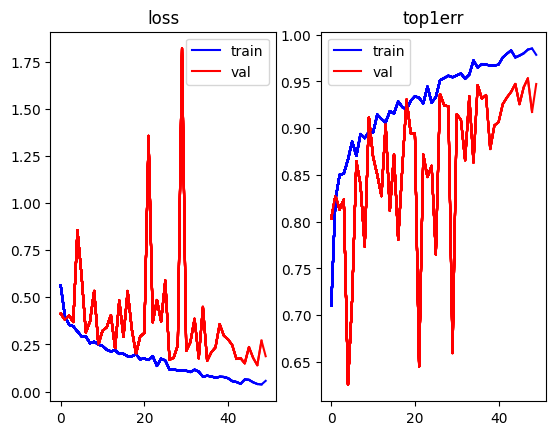

In [ ]:
sattendense = SAttnDense(num_classes=2)
sattendense = sattendense.cuda()
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(sattendense.parameters(), lr=1e-3)
# Decay LR by a factor of 0.7 every 5 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = 0.7, patience = 5, verbose = 1) #from 1e-4
sattendense = train_model(sattendense, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50, model_name='SAttnDense', runs=10)
test_model(test_loader, model=sattendense)
save_model(model=sattendense, model_no=10, model_name= 'SAttnDense')

# Parameters

In [4]:
attendense = AttnDense(num_classes=2)
densenet201 = DenseNet.from_pretrained("densenet201")
model_vgg = models.vgg16(pretrained=True)
model_googlenet = models.googlenet(pretrained=True)
model_res = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

total_params_attndense = sum(p.numel() for p in attendense.parameters())
total_params_dense = sum(p.numel() for p in densenet201.parameters())
total_params_vgg = sum(p.numel() for p in model_vgg.parameters())
total_params_googlenet = sum(p.numel() for p in model_googlenet.parameters())
total_params_res = sum(p.numel() for p in model_res.parameters())

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 185MB/s]


Loaded pretrained weights for densenet201
Loaded pretrained weights for densenet201


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 90.2MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future.

In [6]:
print("vgg-16: "+ str(total_params_vgg/1000000))
print("res50: "+ str(total_params_res/1000000))
print("dense201: "+ str(total_params_dense/1000000))
print("googlenet: "+ str(total_params_googlenet/1000000))
print("attendense: "+ str(total_params_attndense/1000000))

vgg-16: 138.357544
res50: 25.557032
dense201: 20.013928
googlenet: 6.624904
attendense: 19.25123
